# Sentiment Analysis

## 1. Import Package

In [ ]:
pip install xlsxwriter

     |████████████████████████████████| 153kB 2.8MB/s 


In [ ]:
pip install Sastrawi

     |████████████████████████████████| 215kB 2.7MB/s 


In [ ]:
import pandas as pd
import numpy as np
import tweepy
import matplotlib.pyplot as plt
import xlsxwriter

# Machine Learning imports
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

import string
import re
from string import punctuation
from collections import Counter

## 2. GET & Explore Data

In [ ]:
# Call twitter api keys
consumer_key = 'KAJh6RhOHYq4hWqntMjQ1Yuye'
consumer_secret = 'GQBFhGGdaIyTjqFR2vBQI3RC7IQQILpfbbNAfQ0Sc9hzS1MPxp'
access_token = '1106354202559709185-vU27UCeqbCvHUi4snQnatOfvmjvQVF'
access_secret = 'tl8nq2Rxzv7Zp4vmaRMnfSF6r4lTBL0KWUuL9bTu3oC2u'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

In [ ]:
# Search keywords
tweets = tweepy.Cursor(api.search,q="#Pilpres2024",tweet_mode="extended",lang="id").items(100)
message,retweet_count,retweet,created_at,user_name,user_id=[],[],[],[],[],[]
count = 0
for tweet in tweets:
    count=count+1
    if hasattr(tweet, 'retweeted_status'):
        message.append(tweet.retweeted_status.full_text)
        retweet_count.append(tweet.retweet_count)
        retweet.append(tweet.retweeted_status.user.screen_name)
        created_at.append(tweet.created_at)
        user_name.append(tweet.user.screen_name)
        user_id.append(tweet.user.id)
    else:
        message.append(tweet.full_text)
        retweet_count.append(tweet.retweet_count)
        retweet.append(print(''))
        created_at.append(tweet.created_at)
        user_name.append(tweet.user.screen_name)
        user_id.append(tweet.user.id)
# insert tweets to data
for i in range(count):
    data=[message[i], retweet_count[i], retweet[i], created_at[i], user_name[i], user_id[i]]

In [ ]:
# make dataframe
df=pd.DataFrame({
    'author':retweet,
    'username':user_name,
    'retweet_count':retweet_count,
    'tweets':message,
    'created_at':created_at
})
df = df.sort_values(['created_at'], ascending=[0])

In [ ]:
df

,author,username,retweet_count,tweets,created_at
0,None,zuriswanfajri,0,@conan_idn @Fahrihamzah @prabowo @anismatta Sa...,2020-09-20 06:01:01
1,IxNdheso,4di53tiavv,1,*Soeharto dan Zionisme*\n\nHerri Permana\n\nPa...,2020-09-20 05:58:12
2,None,bibin_bey,0,@ChristWamea Mantan Capres (susah susah usaha ...,2020-09-20 04:47:16
3,StrawHatAce,Moonliight22,1,Kalo dia keponakannya prabowo atau anak jendra...,2020-09-20 03:26:52
4,None,StrawHatAce,1,Kalo dia keponakannya prabowo atau anak jendra...,2020-09-20 03:23:18
...,...,...,...,...,...
821,None,gajahganecha,0,"@23_prabowo Aamiin pak presiden , di tunggu pa...",2020-09-11 08:10:24
822,None,Jimi20451740,0,@Dennysiregar7 @aniesbaswedan @Gerindra @prabo...,2020-09-11 08:01:11
823,None,dlonatello,0,"@23_prabowo Masih muda jd presiden, apa tyda t...",2020-09-11 07:55:06
824,None,AbimanaEdzard,0,@iwanchan_ @Dennysiregar7 @aniesbaswedan @Geri...,2020-09-11 07:36:13


In [ ]:
# Uncomment the following lines if you haven't mount to your drive. 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.to_excel("/content/drive/My Drive/Sentimen Analisis/data.xlsx")

In [ ]:
df= pd.read_excel("/content/drive/My Drive/Sentimen Analisis/prabowo.xlsx")
df

,tweets,Komentar
0,RT @eftianto: @detikcom @jokowi @prabowo kelia...,Negatif
1,"RT @shitlicious: Dr td kalo diperhatiin, tiap ...",Negatif
2,@TeddyGusnaidi @woelannnn @prabowo Ada tanah y...,Negatif
3,RT @EllaZefa: Misiii nih ya pak @prabowo sejak...,Negatif
4,RT @MurtadhaOne: MOMENT OF THE DAY\n\nDetik-de...,Negatif
...,...,...
2886,"Fokus. Apapun makanannya, Presiden mendatang I...",Positif
2887,Nurani #Sby Bangkit Dan Langsung Serang Habish...,Negatif
2888,Prabowo: Saya Sudah Muak\r\n\r\n#prabowo #kamp...,Positif
2889,Relawan Makassar Prabowo - Sandi Gelar Jalan S...,Positif


## 3. Preprocessing Data

In [ ]:
# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # To lowercase (case folding)
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

In [ ]:
# clean dataframe's text column
df['tweets'] = df['tweets'].apply(processTweet)
# preview some cleaned tweets
df['tweets'].head()

0    keliatan banget pak prabs gak menguasai masala...
1    kalo diperhatiin tiap pak prabowo menyebut kek...
2    ada tanah rela diserahkan negara untung pak jo...
3    misiii nih pak sejak kapan indonesia impor air...
4    moment the day detik detik kepemilikian tanah ...
Name: tweets, dtype: object

In [ ]:
# drop duplicates
df = df.drop_duplicates('tweets')
df.shape

(1434, 2)

In [ ]:
#stopwords
lstfile = open('/content/drive/My Drive/Sentimen Analisis/stopword.txt','r')
lst = lstfile.readlines()
lst = [x.strip() for x in lst] 
# tokenize helper function
def text_process(raw_text):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in lst]

# -------------------------------------------
# tokenize message column and create a column for tokens
df = df.copy()
df['tokens'] = df['tweets'].apply(text_process)
df[['tweets','tokens']].head(20)

,tweets,tokens
0,keliatan banget pak prabs gak menguasai masala...,"[keliatan, banget, prabs, gak, menguasai, peru..."
1,kalo diperhatiin tiap pak prabowo menyebut kek...,"[kalo, diperhatiin, prabowo, menyebut, kekuran..."
2,ada tanah rela diserahkan negara untung pak jo...,"[tanah, rela, diserahkan, negara, untung, joko..."
3,misiii nih pak sejak kapan indonesia impor air...,"[misiii, nih, indonesia, impor, air, serius, n..."
4,moment the day detik detik kepemilikian tanah ...,"[moment, the, day, detik, detik, kepemilikian,..."
5,wow rupanya sekitar pndkung jainudin byk pengu...,"[wow, pndkung, jainudin, byk, penguasa, lahan,..."
6,prabowo benar benar tidak menguasai persoalan ...,"[prabowo, menguasai, ekonomi, digital, berkemb..."
7,ketika banyak org ngerasa kecewa prabowo gak m...,"[org, ngerasa, kecewa, prabowo, gak, memuaskan..."
8,prabowo unicorn itu yang online online itu dea...,"[prabowo, unicorn, online, online, dear, prabo..."
9,pak prabowo bilang mau memberantas orang yang ...,"[prabowo, bilang, memberantas, orang, suka, ko..."


## 4. Word Cloud

In [ ]:
all_words = []
for line in df['tokens']: 
    all_words.extend(line)  
# create a word frequency dictionary
wordfreq = Counter(all_words)
wordfreq.most_common(10)

[('prabowo', 612),
 ('…', 460),
 ('jokowi', 165),
 ('sandi', 136),
 ('debat', 111),
 ('presiden', 98),
 ('indonesia', 96),
 ('menang', 67),
 ('capres', 64),
 ('gak', 57)]

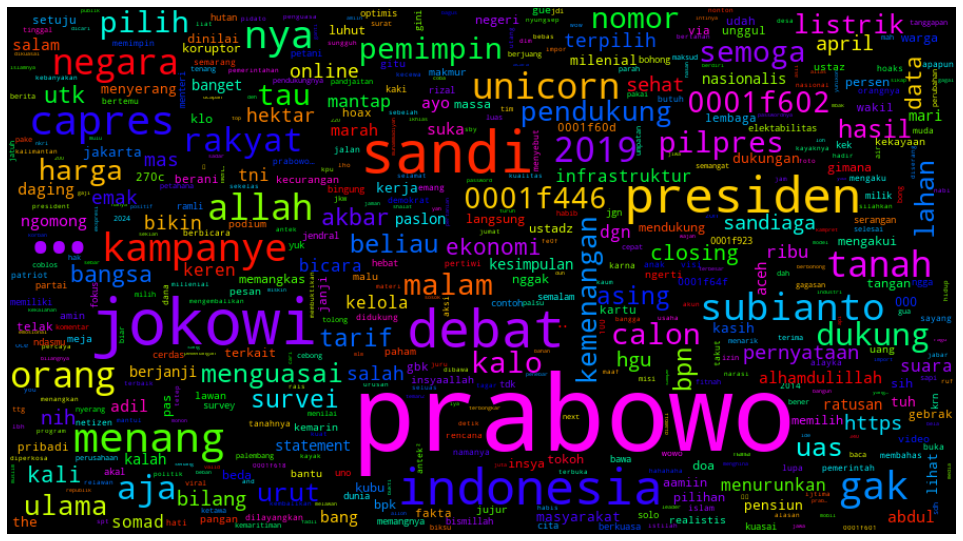

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='gist_rainbow',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 5. Feature Extraction

In [ ]:
# vectorize
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['tweets'])
# print total number of vocab words
print(len(bow_transformer.vocabulary_))
# example of vectorized text
sample_tweet = df['tweets'][0]
print(sample_tweet)
print('\n')
# vector representation
bow_sample = bow_transformer.transform([sample_tweet])
print(bow_sample)
print('\n')

1368
keliatan banget pak prabs gak menguasai masalah padahal perubahan dunia sedang terjadi kadang…


  (0, 119)	1
  (0, 345)	1
  (0, 384)	1
  (0, 579)	1
  (0, 794)	1
  (0, 998)	1




In [ ]:
# transform the entire DataFrame of messages
messages_bow = bow_transformer.transform(df['tweets'])

# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (1434, 1368)
Amount of Non-Zero occurences:  8152


In [ ]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)

  (0, 998)	0.4416139254677536
  (0, 794)	0.37187431762070317
  (0, 579)	0.480698811570933
  (0, 384)	0.3042959678368
  (0, 345)	0.42406153324221757
  (0, 119)	0.4039691389993983


In [ ]:
# to transform the entire bag-of-words corpus
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(1434, 1368)


## 6. Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['tweets'], df['Komentar'], test_size=0.5,random_state=123)


# create pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2),(1,3)],
              'bow__min_df':(2,3,4,5),
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-1,1e-2, 1e-3),
             }

# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)

# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Best Model: 0.730927 using {'bow__min_df': 2, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}


Mean: 0.726643 Stdev:(0.031886) with: {'bow__min_df': 2, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.1, 'tfidf__use_idf': True}
Mean: 0.725313 Stdev:(0.041830) with: {'bow__min_df': 2, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.1, 'tfidf__use_idf': False}
Mean: 0.723865 Stdev:(0.037262) with: {'bow__min_df': 2, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.729519 Stdev:(0.040434) with: {'bow__min_df': 2, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.726663 Stdev:(0.037951) with: {'bow__min_df': 2, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.730927 Stdev:(0.042189) with: {'bow__min_df': 2, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.709898 Stdev:(0.040009) with: {'bow__min_df

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:   29.7s finished


In [ ]:
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )

# get predictions from best model above
y_preds = model_NB.predict(X_test)

print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))

accuracy score:  0.705718270571827


confusion matrix: 
 [[235 130]
 [ 81 271]]


              precision    recall  f1-score   support

     Negatif       0.74      0.64      0.69       365
     Positif       0.68      0.77      0.72       352

    accuracy                           0.71       717
   macro avg       0.71      0.71      0.70       717
weighted avg       0.71      0.71      0.70       717



## 7. Predict

In [ ]:
# run predictions on twitter data
tweet_preds = model_NB.predict(df['tweets'])

# append predictions to dataframe
df_tweet_preds = df.copy()
df_tweet_preds['predictions'] = tweet_preds
df_tweet_preds.shape

(1434, 4)

In [ ]:
df_tweet_preds

,tweets,Komentar,tokens,predictions
0,keliatan banget pak prabs gak menguasai masala...,Negatif,"[keliatan, banget, prabs, gak, menguasai, peru...",Negatif
1,kalo diperhatiin tiap pak prabowo menyebut kek...,Negatif,"[kalo, diperhatiin, prabowo, menyebut, kekuran...",Negatif
2,ada tanah rela diserahkan negara untung pak jo...,Negatif,"[tanah, rela, diserahkan, negara, untung, joko...",Negatif
3,misiii nih pak sejak kapan indonesia impor air...,Negatif,"[misiii, nih, indonesia, impor, air, serius, n...",Negatif
4,moment the day detik detik kepemilikian tanah ...,Negatif,"[moment, the, day, detik, detik, kepemilikian,...",Negatif
...,...,...,...,...
2886,fokus apapun makanannya presiden mendatang ins...,Positif,"[fokus, apapun, makanannya, presiden, insya, a...",Positif
2887,nurani bangkit dan langsung serang habishabisa...,Negatif,"[nurani, bangkit, langsung, serang, habishabis...",Negatif
2888,prabowo saya sudah muak,Positif,"[prabowo, muak]",Positif
2889,relawan makassar prabowo sandi gelar jalan seh...,Positif,"[relawan, makassar, prabowo, sandi, gelar, jal...",Positif


In [ ]:
pos = df_tweet_preds.predictions.value_counts()[0]
neg = df_tweet_preds.predictions.value_counts()[1]

print('Model predictions: Positives - {}, Negatives - {}'.format(neg,pos))

Model predictions: Positives - 668, Negatives - 766
